# SIR model - Denmark

## Inference of parameters 

In this notebook, we consider the SIR model with symptomatically and asymptomatically infected. We are trying to infer the parameters of the model 

* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact), 
* $\gamma_{I_a}$ (rate of recovery for asymptomatic infected individuals), and
* $\gamma_{I_s}$ (rate of recovery for symptomatic infected individuals) 

when given **real data** from Denmark for :
* $S$ (number of susceptible individual), 
* $Is$ (number of symptomatic infected individual until May 5th), 
* $Ia$ (number of asymptomatic individual consider equal to Is), 




In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pyross
import time 

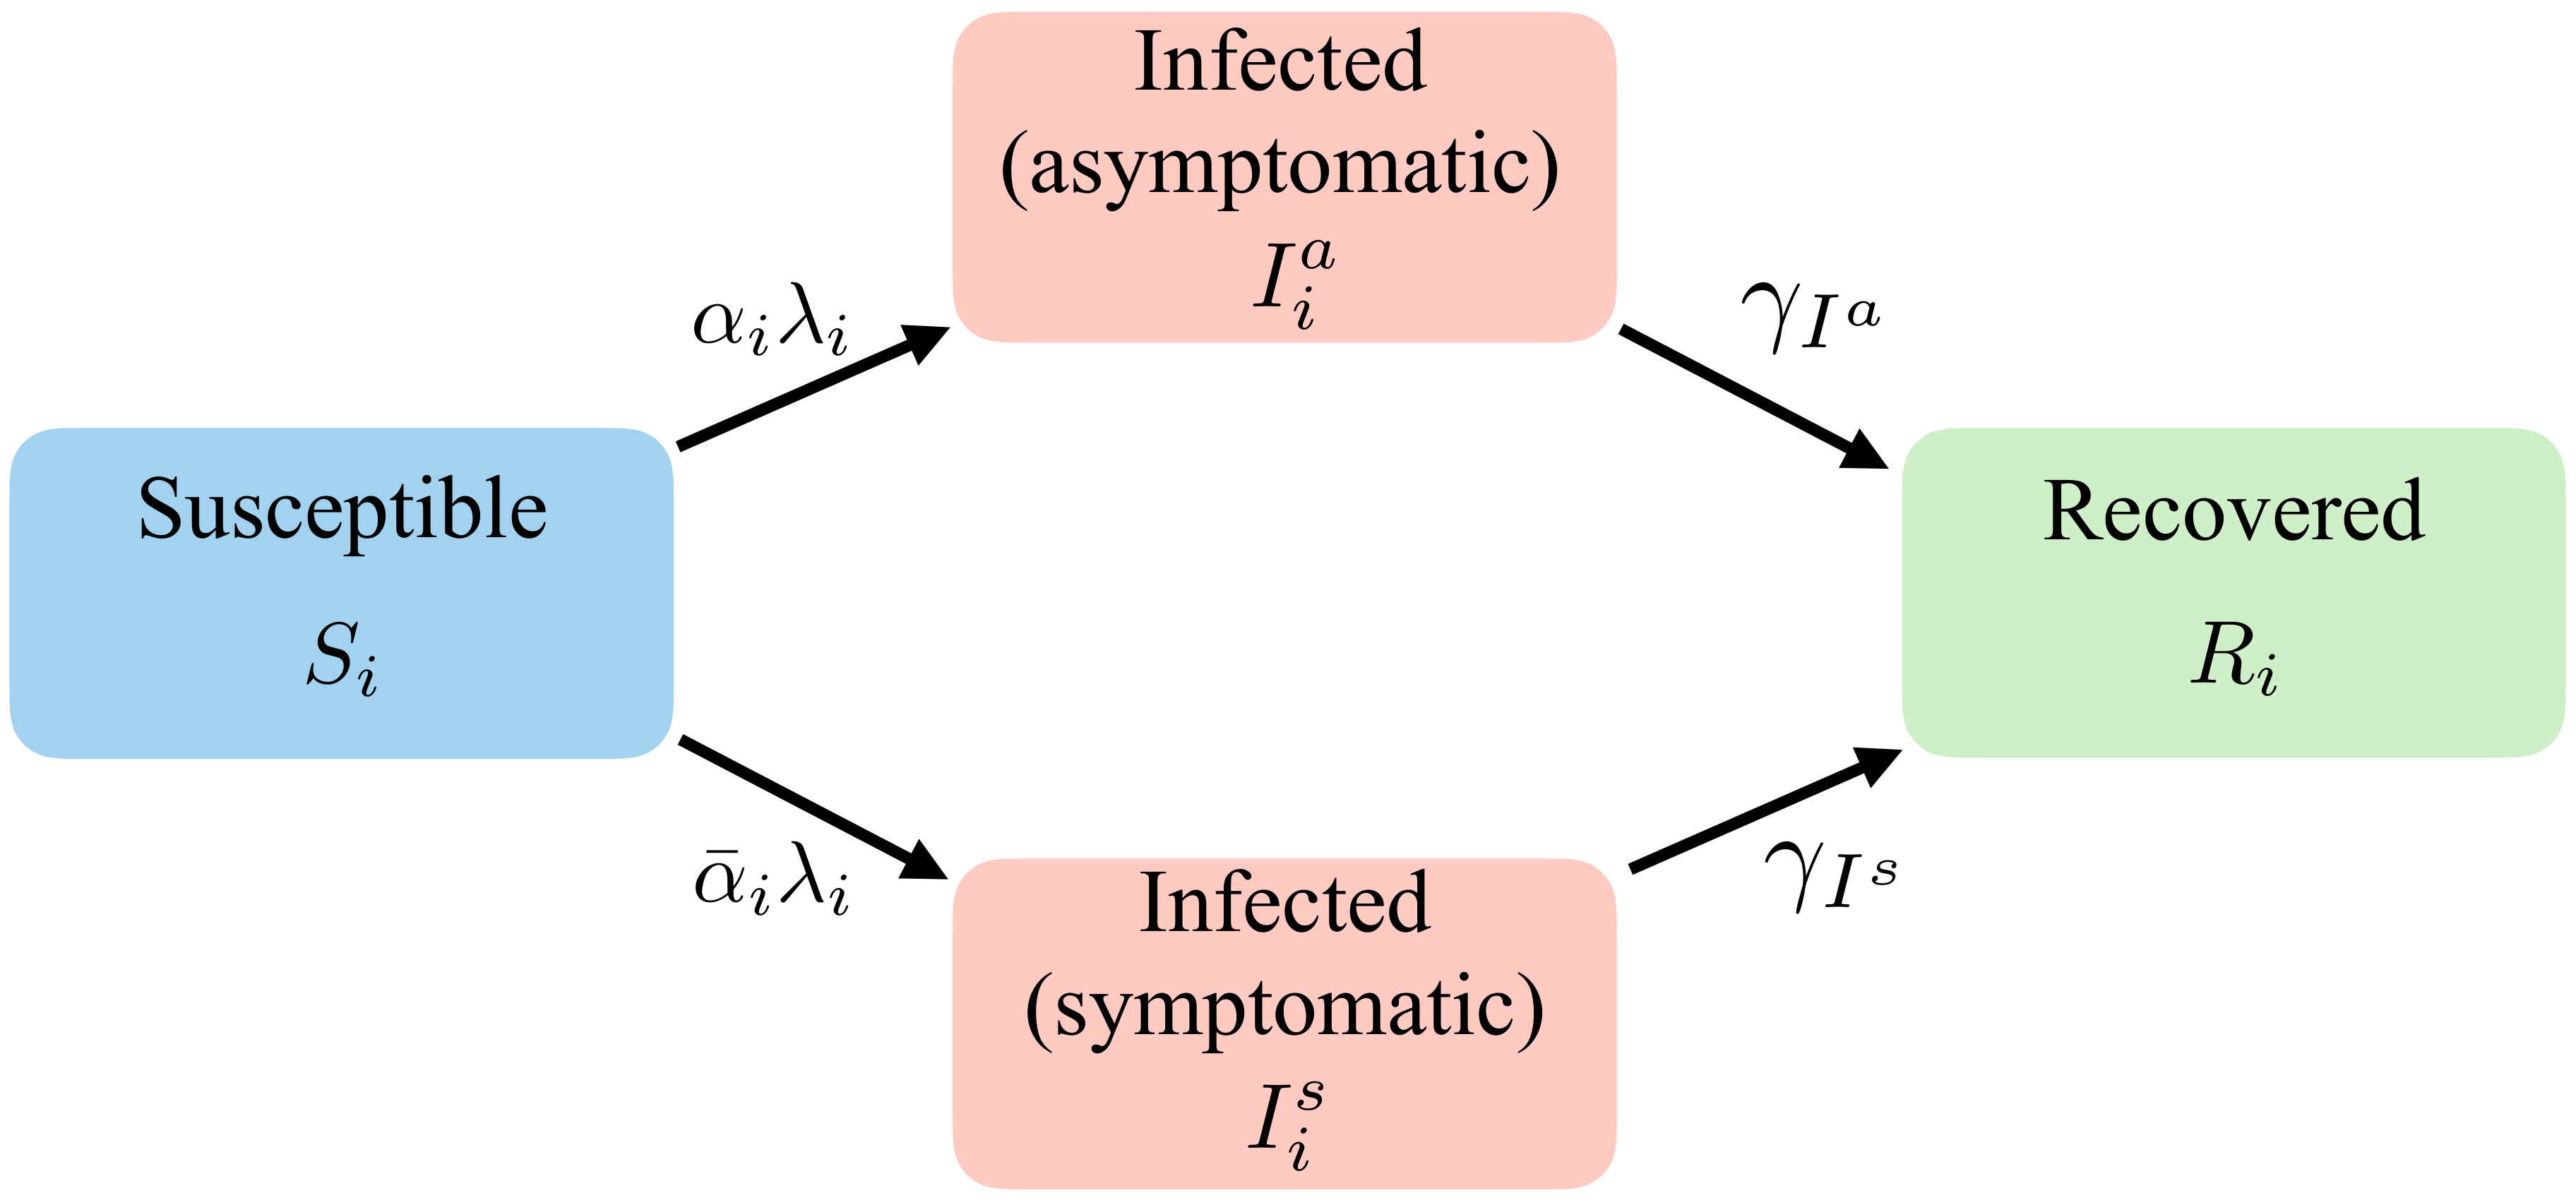

In [3]:
from IPython.display import Image
Image('SIIR.jpg')

## Import all the relevant Denmark data

In [4]:
my_data = np.genfromtxt('../data/age_structures/Denmark-2019.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni0=aM+aF;

M=16  ## number of age classes

Ni = Ni0[:M]
N=np.sum(Ni)

print("Age groups are in brackets of 5 (i.e. 0-4, 5-9, 10-14, .. , 75-79).")
print("Number of individuals in each bracket:")
print(Ni.astype('int'))
print("Total number of individuals: {0}".format(np.sum(Ni.astype('int'))))

Age groups are in brackets of 5 (i.e. 0-4, 5-9, 10-14, .. , 75-79).
Number of individuals in each bracket:
[302353 305513 338779 341219 379522 395469 342443 320132 366147 385944
 422585 381360 338039 319145 346572 220374]
Total number of individuals: 5505596


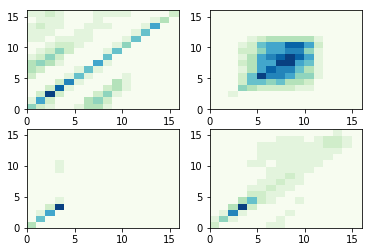

In [5]:
# Get individual contact matrices
CH, CW, CS, CO = pyross.contactMatrix.Denmark()

# By default, home, work, school, and others contribute to the contact matrix
C = CH + CW + CS + CO

# Illustrate the individual contact matrices:
fig,aCF =  plt.subplots(2,2);
aCF[0][0].pcolor(CH, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[0][1].pcolor(CW, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][0].pcolor(CS, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][1].pcolor(CO, cmap=plt.cm.get_cmap('GnBu', 10));

C is the sum of contributions from contacts at home, workplace, schools and all other public spheres. Using superscripts $H$, $W$, $S$ and $O$ for each of these, we write the contact matrix as
$$
C_{ij} = C^H_{ij} + C^W_{ij} + C^S_{ij} + C^O_{ij}
$$

We read in these contact matrices from the data sets provided in the paper *Projecting social contact matrices in 152 countries using contact surveys and demographic data* by Prem et al, sum them to obtain the total contact matrix. We also read in the age distribution of UK obtained from the *Population pyramid* website.

In [6]:
import pandas as pd
denmark_age_structured_case = pd.read_csv('../../denmark_cases_by_age.csv')
case = denmark_age_structured_case.sum(axis=0)[1:]

In [7]:
denmark_age_structured_case.shape

(10, 59)

We will use the real **infective number** for the initial conditions Is and Ia. 

In [8]:
## infective people - remove pp 80 years old + - no contact matrices
nbday = denmark_age_structured_case.shape[1]-1
nbgroup = denmark_age_structured_case.shape[0]
I = np.array(np.zeros([nbday, nbgroup-2]))
for i in range(1,nbday+1):
    I[i-1] = np.array([denmark_age_structured_case.iloc[:,i][:nbgroup-2]])

In [9]:
## we don't want a cum sum 
I[1:] -= I[:-1].copy()

In [10]:
# weird mistake 
I[3,0] = 1

In [11]:
##  duplicate for each subgroup of age 
M = 16
Is = np.array(np.zeros([nbday, M]))
for i in range(I.shape[0]):
    Is[i] = np.array([val for val in I[i]/2 for _ in (0, 1)])

## take only integer values, loosing cases !
for j in range(Is.shape[0]):
    Is[j] = np.array([int(i) for i in Is[j]])

In [12]:
Is.shape

(58, 16)

## Let's create 2 groups young/adults

In [13]:
## young 0-20 years
## medium 20-50 years
## senior 50-80 years

In [14]:
M = 2
Ismod = np.array(np.zeros([nbday, M]))
for i in range(nbday):
    Ismod[i,0] = sum(Is[i,0:5])
#     Ismod[i,1] = sum(Is[i,4:10])
    Ismod[i,1] = sum(Is[i,11:16])

In [15]:
Ismod.shape

(58, 2)

In [16]:
## contact matrix


In [17]:
C1 = np.array(np.zeros([M, M]))
C1[0,0] = int(sum(C[0:5,0:5]).sum())
C1[0,1] = int(sum(C[0:5,11:16]).sum())
C1[1,0] = int(sum(C[11:16,0:5]).sum())
C1[1,1] = int(sum(C[11:16,11:16]).sum())

In [18]:
C = C1

In [19]:
Nimod = np.array(np.zeros([M]))
Nimod[0] = sum(Ni[0:5])
Nimod[1] =sum(Ni[11:16])

In [20]:
Ni = Nimod

In [21]:
N=np.sum(Ni)
N

3272876.0

In [22]:
C

array([[44.,  2.],
       [ 9., 14.]])

## 1) Run one simulation 
We generate a test trajectory on a population with two ages groups.

In [201]:
beta  = 0.015           # infection rate 

gE    = 1/5.
gA    = 1/4.
gIa   = 1./7.                # recovery rate of asymptomatic infectives 
gIs   = 1./20.                # recovery rate of symptomatic infectives 
alpha = 0.5               # fraction of asymptomatic infectives 
fsa   = 0.2    


# initial conditions    
Is0 = Ismod[1,]
Ia0 = Ismod[1,]
R0  = np.zeros((M))
S0  = Ni - (Ia0 + Is0 + R0)

In [202]:
## matrix with all events
def contactMatrix(t):
    return C

In [203]:
# fraction of population in Age group
fi = Ni/sum(Ni)
Ni = N*fi

## Model

In [204]:
print('M :', M)
print('Ni :', Ni)
print('N :', N)
print('C :', C)
print('Ia0 :', Ia0)
print('Is0 :', Is0)
print('S0 :', S0)
print('R0 :', R0)

M : 2
Ni : [1667386. 1605490.]
N : 3272876.0
C : [[44.  2.]
 [ 9. 14.]]
Ia0 : [ 7. 40.]
Is0 : [ 7. 40.]
S0 : [1667372. 1605410.]
R0 : [0. 0.]


In [205]:
Tf = 100
Nf = Tf+1

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
true_parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SIR(parameters, M, Ni)
data = sto_model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('SIR_sto_traj.npy', data_array)

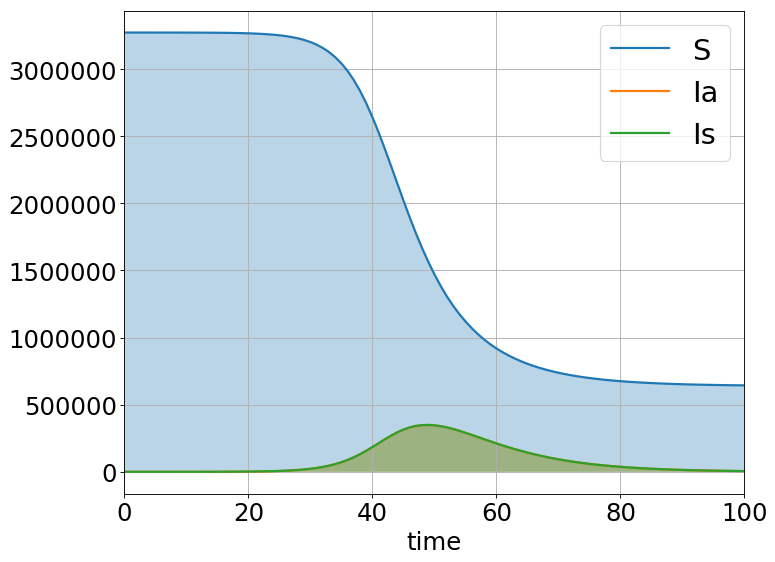

In [206]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
t = data['t']

plt.fill_between(t, 0, np.sum(data_array[:, :M], axis=1),  alpha=0.3)
plt.plot(t, np.sum(data_array[:, :M], axis=1), '-', label='S', lw=2)

plt.fill_between(t, 0, np.sum(data_array[:, M:2*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, M:2*M], axis=1), '-', label='Ia', lw=2)

plt.fill_between(t, 0, np.sum(data_array[:, 2*M:3*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), '-', label='Is', lw=2)

plt.legend(fontsize=26)
plt.grid() 
plt.xlabel(r'time') 
plt.autoscale(enable=True, axis='x', tight=True)

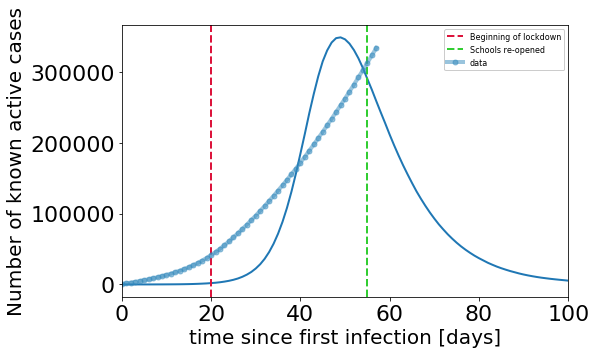

In [207]:
y_plot = np.sum(data_array[:, 2*M:3*M], axis=1)


lw=2
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(t,y_plot,lw=lw,)
ax.axvline(20,
           color='crimson',lw=lw,
          label='Beginning of lockdown',ls='--')
ax.axvline(55,
color='limegreen',lw=lw,
          label='Schools re-opened',ls='--')

ax.plot(np.cumsum(np.array(case)), 'o-', lw=4, color='#348ABD', ms=5, label='data', alpha=0.5)


ax.set_xlim(0,Tf)
fs=20
ax.legend(loc='best',fontsize=8,framealpha=1)
ax.set_xlabel('time since first infection [days]',fontsize=fs)
ax.set_ylabel('Number of known active cases',fontsize=fs)
plt.show(fig)



The model is predicting too many infected individuals.

In [208]:
plt.savefig('denmarkSIR.png')

<Figure size 432x288 with 0 Axes>

## 2) Inference
We take the first real points and use them to infer the parameters of the model.

In [209]:
# load the oberved data
Tf_inference = 49
Nf_inference = Tf_inference+1

In [210]:
x = np.load('SIR_sto_traj.npy').astype('float')
x.shape

(101, 6)

In [211]:
## Is non cumulative - 52 days from the data - overwrite 
dayobs = 50
x[:dayobs,2*M:3*M] = Ismod[:dayobs ,]

In [212]:
x.shape 

(101, 6)

In [213]:
x = (x/N)[:Nf_inference]
x.shape

(50, 6)

In [214]:
# fraction of population in Age group
fi = Ni/sum(Ni)

In [215]:
# initialise the estimator 
steps =101
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)

In [216]:
# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf_inference, Nf_inference, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

1698426.9614689625
0.2394120693206787


In [217]:
# Define the prior (Gamma prior around guess of parameter with defined std. deviation)
alpha_g = 0.3
beta_g = 0.000000001
gIa_g = 1/5
gIs_g = 1/10


# compute -log_p for the initial guess 
parameters = {'alpha':alpha_g, 'beta':beta_g, 'gIa':gIa_g, 'gIs':gIs_g, 'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf_inference, Nf_inference, contactMatrix)
print(logp) 

17519533388074.188


In [218]:
eps = 1e-9
# the names of the parameters to be inferred 
keys = ['alpha', 'beta', 'gIa', 'gIs']

# initial guess 
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g])  

# error bars on the initial guess 
alpha_std = 0.2
beta_std = 0.1
gIa_std = 0.1
gIs_std = 0.1
stds = np.array([alpha_std, beta_std , gIa_std, gIs_std])

# bounds on the parameters 
bounds = np.array([(eps, 0.8), (eps, 0.2), (eps, 0.6), (eps, 0.6)]) 

# Stopping criterion for minimisation (relative change in function value)
ftol = 1e-6  
start_time = time.time() 
params = estimator.infer_parameters(keys, guess, stds, bounds, x, Tf_inference, Nf_inference, 
                                    contactMatrix, 
                                    global_max_iter=20,
                                    local_max_iter=200, 
                                    global_ftol_factor=1e3, 
                                    ftol=ftol, 
                                    verbose=True)
end_time = time.time()

print(params) # best guess 
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 4 (seed=1932244806, Thu May 28 15:46:40 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 7.512938175187412e+05 1.0e+00 1.19e+00  1e-01  2e-01 0:01.4
    2     32 4.530074719137441e+05 1.7e+00 1.37e+00  1e-01  3e-01 0:03.3
    3     48 6.849674822006689e+05 2.1e+00 1.34e+00  1e-01  3e-01 0:06.6
    5     80 2.816954502722142e+05 2.2e+00 1.27e+00  8e-02  3e-01 0:10.9
    8    128 2.809933565664853e+05 2.9e+00 1.29e+00  7e-02  3e-01 0:16.6
   11    176 2.421784552337768e+05 1.9e+00 1.47e+00  8e-02  2e-01 0:23.4
   14    224 2.442280147630803e+05 1.7e+00 1.08e+00  5e-02  1e-01 0:30.6
   19    304 3.206607003653928e+05 4.2e+00 7.18e-01  1e-02  8e-02 0:38.8
Optimal value (global minimisation):  194785.8402280322
Starting local minimisation...
Optimal value (local minimisation):  162865.3577255143
[0.8        0.01990264 0.34994339 0.6       ]
66.64378714561462


In [219]:
# compute log_p for best estimate 
start_time = time.time() 
new_parameters = estimator.fill_params_dict(keys, params)
logp = estimator.obtain_minus_log_p(new_parameters, x, Tf_inference, Nf_inference, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

162826.90793274215
0.32647013664245605


In [220]:
print("True parameters:")
print(true_parameters)

print("\nInferred parameters:")
print(new_parameters)

True parameters:
{'alpha': 0.5, 'beta': 0.015, 'gIa': 0.14285714285714285, 'gIs': 0.05, 'fsa': 0.2}

Inferred parameters:
{'alpha': 0.8, 'beta': 0.019902642116400693, 'gIa': 0.3499433889067114, 'gIs': 0.6, 'fsa': 0.2}


True parameters:
{'alpha': 0.8, 'beta': 0.0076692, 'gIa': 0.14285714285714285, 'gIs': 0.05, 'fsa': 0.2}

Inferred parameters:
{'alpha': 0.7999999483513327, 'beta': 0.008710691410228559, 'gIa': 0.18841652250810673, 'gIs': 0.6, 'fsa': 0.2}

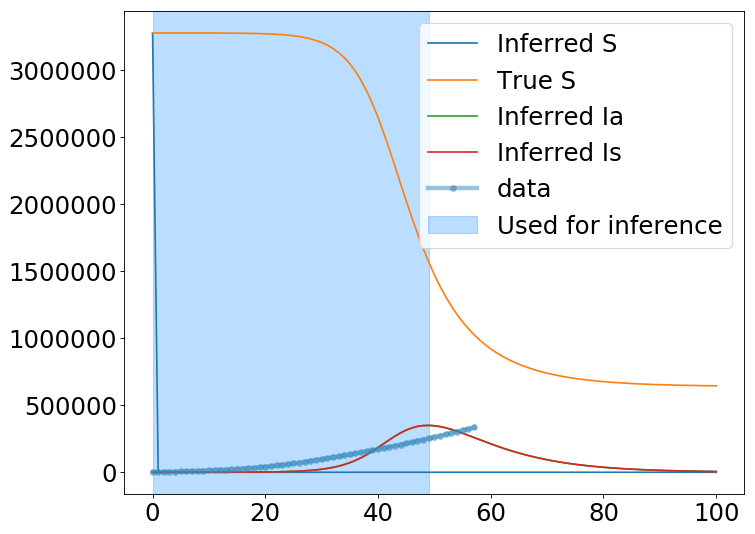

In [221]:
x = np.load('SIR_sto_traj.npy').astype('float') 
Nf = x.shape[0]
Tf = Nf-1

det_model = pyross.deterministic.SIR(new_parameters, int(M), fi)
x_det = estimator.integrate(x[0], 0, Tf, Nf, det_model, contactMatrix)
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(np.sum(x_det[:, :M], axis=1), label='Inferred S')
plt.plot(np.sum(x[:, :M], axis=1), label='True S')
plt.plot(np.sum(x[:, M:2*M], axis=1), label='Inferred Ia')
# plt.plot(np.sum(x[:, M:2*M], axis=1), label='True Ia')
plt.plot(np.sum(x[:, 2*M:3*M], axis=1), label='Inferred Is')
# plt.plot(np.sum(x[:, 2*M:3*M], axis=1), label='True Is')
# plt.xlim([0, Tf])
plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')

plt.plot(np.cumsum(np.array(case)), 'o-', lw=4, color='#348ABD', ms=5, label='data', alpha=0.5)
plt.legend()
plt.show() 
# plt.savefig('denmarkSIRinfer.png')

In [222]:
print("True parameters:")
print(true_parameters)

print("\nInferred parameters:")
print(new_parameters)

True parameters:
{'alpha': 0.5, 'beta': 0.015, 'gIa': 0.14285714285714285, 'gIs': 0.05, 'fsa': 0.2}

Inferred parameters:
{'alpha': 0.8, 'beta': 0.019902642116400693, 'gIa': 0.3499433889067114, 'gIs': 0.6, 'fsa': 0.2}


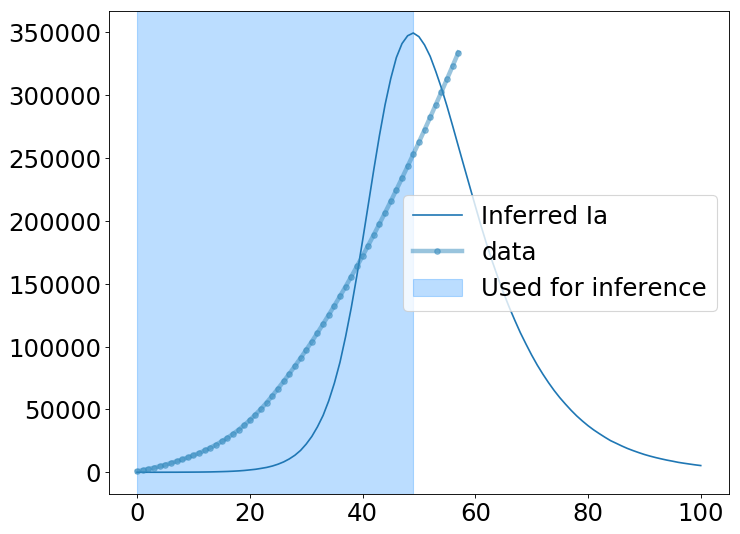

In [224]:
x = np.load('SIR_sto_traj.npy').astype('float') 
Nf = x.shape[0]
Tf = Nf-1

det_model = pyross.deterministic.SIR(new_parameters, int(M), fi)
x_det = estimator.integrate(x[0], 0, Tf, Nf, det_model, contactMatrix)
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
# plt.plot(np.sum(x_det[:, :M], axis=1), label='Inferred S')
# plt.plot(np.sum(x[:, :M], axis=1), label='True S')
plt.plot(np.sum(x[:, M:2*M], axis=1), label='Inferred Ia')
# plt.plot(np.sum(x[:, M:2*M], axis=1), label='True Ia')
# plt.plot(np.sum(x[:, 2*M:3*M], axis=1), label='Inferred Is')
# plt.plot(np.sum(x[:, 2*M:3*M], axis=1), label='True Is')
# plt.xlim([0, Tf])
plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')

plt.plot(np.cumsum(np.array(case)), 'o-', lw=4, color='#348ABD', ms=5, label='data', alpha=0.5)
plt.legend()
plt.show() 
# plt.savefig('denmarkSIRinfer.png')